# ASL Recognition: Improved End-to-End Training with Regularization

This notebook implements an improved training workflow for ASL recognition with:

1. Advanced model architectures (GRU, LSTM)
2. Data augmentation for time series data
3. Enhanced regularization techniques
4. Learning rate scheduling
5. Cross-validation
6. Model evaluation and visualization


In [20]:
# Import Required Libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Import custom modules
from improved_models import ImprovedRNNModel, LSTMModel
from data_augmentation import TimeseriesAugmenter
from model_trainer import ModelTrainer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Loading and Preprocessing

We'll load the preprocessed keypoints from the JSON files and normalize them.


In [15]:
# Configuration
DATA_DIR = Path(r'f:\Uni_Stuff\6th_Sem\DL\Proj\video-asl-recognition\pose_estimation\data\keypoints')

# Load and normalize keypoints (reusing the function from model_training.ipynb)
def load_keypoints(data_dir):
    data = []
    labels = []
    skipped_files = 0
    processed_files = 0
    print(f"Loading keypoints from {data_dir}")
    # Gather all json files from all label directories
    all_json_files = []
    for label_dir in data_dir.iterdir():
        if label_dir.is_dir():
            all_json_files.extend(list(label_dir.glob('*.json')))
    # Use a single tqdm progress bar for all files
    for json_file in tqdm(all_json_files, desc="Loading keypoint files"):
        try:
            with open(json_file, 'r') as f:
                content = json.load(f)
                if 'keypoints' not in content or 'label' not in content:
                    skipped_files += 1
                    continue
                keypoints = content['keypoints']
                label = content['label']
                processed_frames = []
                for frame in keypoints:
                    left_hand_features = np.zeros(63, dtype=np.float32)
                    right_hand_features = np.zeros(63, dtype=np.float32)
                    pose_features = np.zeros(99, dtype=np.float32)
                    if 'hands' in frame and frame['hands']:
                        for i, hand in enumerate(frame['hands']):
                            if i < 2:
                                hand_features = []
                                for point in hand:
                                    if isinstance(point, list) and len(point) == 3:
                                        hand_features.extend(point)
                                if i == 0 and len(hand_features) <= 63:
                                    left_hand_features[:len(hand_features)] = hand_features
                                elif i == 1 and len(hand_features) <= 63:
                                    right_hand_features[:len(hand_features)] = hand_features
                    if 'pose' in frame and frame['pose']:
                        pose_data = []
                        for point in frame['pose']:
                            if isinstance(point, list) and len(point) == 3:
                                pose_data.extend(point)
                        if len(pose_data) <= 99:
                            pose_features[:len(pose_data)] = pose_data
                    frame_features = np.concatenate([left_hand_features, right_hand_features, pose_features])
                    processed_frames.append(frame_features)
                if processed_frames:
                    processed_data = np.array(processed_frames, dtype=np.float32)
                    if processed_data.shape[0] > 0 and processed_data.shape[1] > 0:
                        data.append(processed_data)
                        labels.append(label)
                        processed_files += 1
                    else:
                        skipped_files += 1
                else:
                    skipped_files += 1
        except Exception as e:
            skipped_files += 1
    print(f"Processed {processed_files} files successfully, skipped {skipped_files} files")
    if not data:
        print("Warning: No valid data was loaded!")
        return np.array([]), np.array([])
    max_seq_len = max(sample.shape[0] for sample in data)
    feature_dim = data[0].shape[1]
    padded_data = []
    for sample in data:
        if sample.shape[0] < max_seq_len:
            padding = np.zeros((max_seq_len - sample.shape[0], feature_dim), dtype=np.float32)
            padded_sample = np.vstack((sample, padding))
        else:
            padded_sample = sample[:max_seq_len]
        padded_data.append(padded_sample)
    return np.array(padded_data), np.array(labels)

# Load data
data, labels = load_keypoints(DATA_DIR)

Loading keypoints from f:\Uni_Stuff\6th_Sem\DL\Proj\video-asl-recognition\pose_estimation\data\keypoints


Loading keypoint files: 100%|██████████| 3202/3202 [00:22<00:00, 143.22it/s]


Processed 3202 files successfully, skipped 0 files


# Feature Normalization and Preprocessing

We'll normalize the features to improve training stability.


In [21]:
# Normalize the input features
def normalize_features(data):
    # Reshape to (samples * timesteps, features)
    flattened_data = data.reshape(-1, data.shape[2])
    
    # Calculate mean and standard deviation
    mean = np.mean(flattened_data, axis=0)
    std = np.std(flattened_data, axis=0)
    
    # Replace zeros in std to avoid division by zero
    std[std < 1e-10] = 1.0
    
    # Normalize
    normalized_data = (flattened_data - mean) / std
    
    # Reshape back
    normalized_data = normalized_data.reshape(data.shape)
    
    return normalized_data, mean, std

# Normalize data
normalized_data, feat_mean, feat_std = normalize_features(data)
print(f"Data shape after normalization: {normalized_data.shape}")

# Create a mapping from string labels to numeric indices
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
print(f"Label to index mapping: {label_to_index}")

# Convert string labels to numeric indices
numeric_labels = np.array([label_to_index[label] for label in labels])
print(f"Converted labels to numeric indices.")

Data shape after normalization: (3202, 60, 225)
Label to index mapping: {'about': 0, 'accident': 1, 'africa': 2, 'again': 3, 'all': 4, 'always': 5, 'animal': 6, 'apple': 7, 'approve': 8, 'argue': 9, 'arrive': 10, 'baby': 11, 'back': 12, 'backpack': 13, 'bad': 14, 'bake': 15, 'balance': 16, 'ball': 17, 'banana': 18, 'bar': 19, 'basketball': 20, 'bath': 21, 'bathroom': 22, 'beard': 23, 'because': 24, 'bed': 25, 'before': 26, 'behind': 27, 'bird': 28, 'birthday': 29, 'black': 30, 'blanket': 31, 'blue': 32, 'book': 33, 'bowling': 34, 'boy': 35, 'bring': 36, 'brother': 37, 'brown': 38, 'business': 39, 'but': 40, 'buy': 41, 'call': 42, 'can': 43, 'candy': 44, 'careful': 45, 'cat': 46, 'catch': 47, 'center': 48, 'cereal': 49, 'chair': 50, 'champion': 51, 'change': 52, 'chat': 53, 'cheat': 54, 'check': 55, 'cheese': 56, 'children': 57, 'christmas': 58, 'city': 59, 'class': 60, 'clock': 61, 'close': 62, 'clothes': 63, 'coffee': 64, 'cold': 65, 'college': 66, 'color': 67, 'computer': 68, 'convin

# Enhanced Dataset (No Data Augmentation)

We'll create a dataset class without augmentation for now to avoid augmentation-related errors.


In [22]:
class ASLDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Split the dataset: train (70%), validation (15%), test (15%) 
X_train, X_temp, y_train, y_temp = train_test_split(
    normalized_data, numeric_labels, test_size=0.3, 
    stratify=numeric_labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, 
    stratify=y_temp, random_state=42
)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Create datasets (no augmentation)
train_dataset = ASLDataset(X_train, y_train)
val_dataset = ASLDataset(X_val, y_val)
test_dataset = ASLDataset(X_test, y_test)

# Create data loaders with appropriate batch sizes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Training set: (2241, 60, 225), Validation set: (480, 60, 225), Test set: (481, 60, 225)


# Model Selection and Hyperparameter Settings (RNN, GRU, LSTM)

We'll define and compare RNN, GRU, and LSTM architectures (no Transformer).


In [23]:
# Model parameters
input_size = normalized_data.shape[2]  # Number of features per time step
hidden_size = 128
output_size = len(np.unique(labels))
num_layers = 2
dropout_rate = 0.3
bidirectional = True

print(f"Input size: {input_size}")
print(f"Output size (num classes): {output_size}")

# Define model architectures to compare
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.3, bidirectional=True):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out)

class SimpleGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.3, bidirectional=True):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

class SimpleLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.3, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

models = {
    "RNN": SimpleRNNModel(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=output_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional
    ),
    "GRU": SimpleGRUModel(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=output_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional
    ),
    "LSTM": SimpleLSTMModel(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=output_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional
    )
}

# Print model structure
for name, model in models.items():
    print(f"\n{name} Model:")
    print(model)
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Input size: 225
Output size (num classes): 300

RNN Model:
SimpleRNNModel(
  (rnn): RNN(225, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=300, bias=True)
)
Number of parameters: 266796

GRU Model:
SimpleGRUModel(
  (gru): GRU(225, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=300, bias=True)
)
Number of parameters: 646188

LSTM Model:
SimpleLSTMModel(
  (lstm): LSTM(225, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=300, bias=True)
)
Number of parameters: 835884


# Train the Models Using the Advanced Trainer

We'll train each model using the enhanced ModelTrainer class with learning rate scheduling and regularization.



===== Training RNN Model =====


Validation: 100%|██████████| 15/15 [00:00<00:00, 540.93it/s]



Epoch 1/50, Train Loss: 5.7704, Train Acc: 0.0036, Val Loss: 5.7277, Val Acc: 0.0042
Model improved! Best val loss: 5.7277


Validation: 100%|██████████| 15/15 [00:00<00:00, 442.23it/s]



Epoch 2/50, Train Loss: 5.6501, Train Acc: 0.0071, Val Loss: 5.7174, Val Acc: 0.0042
Model improved! Best val loss: 5.7174


Validation: 100%|██████████| 15/15 [00:00<00:00, 527.78it/s]



Epoch 3/50, Train Loss: 5.5461, Train Acc: 0.0085, Val Loss: 5.6818, Val Acc: 0.0083
Model improved! Best val loss: 5.6818


Validation: 100%|██████████| 15/15 [00:00<00:00, 444.63it/s]



Epoch 4/50, Train Loss: 5.4238, Train Acc: 0.0147, Val Loss: 5.6355, Val Acc: 0.0104
Model improved! Best val loss: 5.6355


Validation: 100%|██████████| 15/15 [00:00<00:00, 500.02it/s]



Epoch 5/50, Train Loss: 5.3303, Train Acc: 0.0156, Val Loss: 5.5978, Val Acc: 0.0187
Model improved! Best val loss: 5.5978


Validation: 100%|██████████| 15/15 [00:00<00:00, 495.24it/s]



Epoch 6/50, Train Loss: 5.2526, Train Acc: 0.0183, Val Loss: 5.5635, Val Acc: 0.0167
Model improved! Best val loss: 5.5635


Validation: 100%|██████████| 15/15 [00:00<00:00, 535.90it/s]



Epoch 7/50, Train Loss: 5.1640, Train Acc: 0.0250, Val Loss: 5.5335, Val Acc: 0.0187
Model improved! Best val loss: 5.5335


Validation: 100%|██████████| 15/15 [00:00<00:00, 508.04it/s]


Epoch 8/50, Train Loss: 5.1306, Train Acc: 0.0348, Val Loss: 5.5469, Val Acc: 0.0187
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 499.47it/s]



Epoch 9/50, Train Loss: 5.0638, Train Acc: 0.0219, Val Loss: 5.4732, Val Acc: 0.0208
Model improved! Best val loss: 5.4732


Validation: 100%|██████████| 15/15 [00:00<00:00, 577.33it/s]



Epoch 10/50, Train Loss: 4.9481, Train Acc: 0.0259, Val Loss: 5.4654, Val Acc: 0.0167
Model improved! Best val loss: 5.4654


Validation: 100%|██████████| 15/15 [00:00<00:00, 510.05it/s]


Epoch 11/50, Train Loss: 4.8852, Train Acc: 0.0366, Val Loss: 5.4569, Val Acc: 0.0104
Model improved! Best val loss: 5.4569


Validation: 100%|██████████| 15/15 [00:00<00:00, 445.37it/s]


Epoch 12/50, Train Loss: 4.7891, Train Acc: 0.0361, Val Loss: 5.4772, Val Acc: 0.0208
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 452.45it/s]


Epoch 13/50, Train Loss: 4.7780, Train Acc: 0.0473, Val Loss: 5.4690, Val Acc: 0.0167
Early stopping counter: 2/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 338.19it/s]


Epoch 14/50, Train Loss: 4.7281, Train Acc: 0.0424, Val Loss: 5.4970, Val Acc: 0.0187
Early stopping counter: 3/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 466.59it/s]


Epoch 15/50, Train Loss: 4.6632, Train Acc: 0.0482, Val Loss: 5.5240, Val Acc: 0.0167
Early stopping counter: 4/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 576.02it/s]


Epoch 16/50, Train Loss: 4.5760, Train Acc: 0.0598, Val Loss: 5.5022, Val Acc: 0.0208
Early stopping counter: 5/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 488.63it/s]



Epoch 17/50, Train Loss: 4.8020, Train Acc: 0.0527, Val Loss: 5.8945, Val Acc: 0.0125
Early stopping counter: 6/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 447.83it/s]



Epoch 18/50, Train Loss: 4.8989, Train Acc: 0.0321, Val Loss: 5.7023, Val Acc: 0.0229
Early stopping counter: 7/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 409.46it/s]



Epoch 19/50, Train Loss: 4.8196, Train Acc: 0.0379, Val Loss: 5.5666, Val Acc: 0.0125
Early stopping counter: 8/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 486.21it/s]


Epoch 20/50, Train Loss: 4.7069, Train Acc: 0.0437, Val Loss: 5.5441, Val Acc: 0.0167
Early stopping counter: 9/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 401.54it/s]



Epoch 21/50, Train Loss: 4.6524, Train Acc: 0.0469, Val Loss: 5.5769, Val Acc: 0.0167
Early stopping counter: 10/10
Early stopping triggered after 21 epochs
Training completed in 0.16 minutes

RNN Training History:

===== Training GRU Model =====


Validation: 100%|██████████| 15/15 [00:00<00:00, 334.63it/s]



Epoch 1/50, Train Loss: 5.7368, Train Acc: 0.0018, Val Loss: 5.7071, Val Acc: 0.0042
Model improved! Best val loss: 5.7071


Validation: 100%|██████████| 15/15 [00:00<00:00, 309.33it/s]



Epoch 2/50, Train Loss: 5.6188, Train Acc: 0.0143, Val Loss: 5.6803, Val Acc: 0.0063
Model improved! Best val loss: 5.6803


Validation: 100%|██████████| 15/15 [00:00<00:00, 327.53it/s]



Epoch 3/50, Train Loss: 5.4801, Train Acc: 0.0143, Val Loss: 5.5788, Val Acc: 0.0125
Model improved! Best val loss: 5.5788


Validation: 100%|██████████| 15/15 [00:00<00:00, 301.70it/s]



Epoch 4/50, Train Loss: 5.2946, Train Acc: 0.0165, Val Loss: 5.4611, Val Acc: 0.0125
Model improved! Best val loss: 5.4611


Validation: 100%|██████████| 15/15 [00:00<00:00, 250.28it/s]



Epoch 5/50, Train Loss: 5.1597, Train Acc: 0.0214, Val Loss: 5.3950, Val Acc: 0.0229
Model improved! Best val loss: 5.3950


Validation: 100%|██████████| 15/15 [00:00<00:00, 269.37it/s]



Epoch 6/50, Train Loss: 5.0198, Train Acc: 0.0330, Val Loss: 5.3569, Val Acc: 0.0250
Model improved! Best val loss: 5.3569


Validation: 100%|██████████| 15/15 [00:00<00:00, 312.16it/s]



Epoch 7/50, Train Loss: 4.8721, Train Acc: 0.0446, Val Loss: 5.3167, Val Acc: 0.0187
Model improved! Best val loss: 5.3167


Validation: 100%|██████████| 15/15 [00:00<00:00, 285.20it/s]



Epoch 8/50, Train Loss: 4.7943, Train Acc: 0.0348, Val Loss: 5.2736, Val Acc: 0.0271
Model improved! Best val loss: 5.2736


Validation: 100%|██████████| 15/15 [00:00<00:00, 291.83it/s]



Epoch 9/50, Train Loss: 4.6537, Train Acc: 0.0477, Val Loss: 5.2125, Val Acc: 0.0333
Model improved! Best val loss: 5.2125


Validation: 100%|██████████| 15/15 [00:00<00:00, 255.69it/s]



Epoch 10/50, Train Loss: 4.5736, Train Acc: 0.0576, Val Loss: 5.1306, Val Acc: 0.0333
Model improved! Best val loss: 5.1306


Validation: 100%|██████████| 15/15 [00:00<00:00, 278.63it/s]



Epoch 11/50, Train Loss: 4.4151, Train Acc: 0.0616, Val Loss: 5.0792, Val Acc: 0.0437
Model improved! Best val loss: 5.0792


Validation: 100%|██████████| 15/15 [00:00<00:00, 264.55it/s]



Epoch 12/50, Train Loss: 4.1896, Train Acc: 0.0745, Val Loss: 4.9859, Val Acc: 0.0479
Model improved! Best val loss: 4.9859


Validation: 100%|██████████| 15/15 [00:00<00:00, 321.58it/s]



Epoch 13/50, Train Loss: 4.1642, Train Acc: 0.0834, Val Loss: 4.9240, Val Acc: 0.0479
Model improved! Best val loss: 4.9240


Validation: 100%|██████████| 15/15 [00:00<00:00, 308.81it/s]



Epoch 14/50, Train Loss: 3.9241, Train Acc: 0.1178, Val Loss: 4.8783, Val Acc: 0.0604
Model improved! Best val loss: 4.8783


Validation: 100%|██████████| 15/15 [00:00<00:00, 332.14it/s]



Epoch 15/50, Train Loss: 3.8064, Train Acc: 0.1111, Val Loss: 4.8358, Val Acc: 0.0563
Model improved! Best val loss: 4.8358


Validation: 100%|██████████| 15/15 [00:00<00:00, 309.94it/s]



Epoch 16/50, Train Loss: 3.6398, Train Acc: 0.1249, Val Loss: 4.7873, Val Acc: 0.0688
Model improved! Best val loss: 4.7873


Validation: 100%|██████████| 15/15 [00:00<00:00, 327.05it/s]



Epoch 17/50, Train Loss: 3.7490, Train Acc: 0.1437, Val Loss: 4.7495, Val Acc: 0.0583
Model improved! Best val loss: 4.7495


Validation: 100%|██████████| 15/15 [00:00<00:00, 352.63it/s]



Epoch 18/50, Train Loss: 3.3841, Train Acc: 0.1807, Val Loss: 4.6806, Val Acc: 0.0667
Model improved! Best val loss: 4.6806


Validation: 100%|██████████| 15/15 [00:00<00:00, 281.70it/s]



Epoch 19/50, Train Loss: 3.4196, Train Acc: 0.1673, Val Loss: 4.6670, Val Acc: 0.0688
Model improved! Best val loss: 4.6670


Validation: 100%|██████████| 15/15 [00:00<00:00, 352.95it/s]



Epoch 20/50, Train Loss: 3.2613, Train Acc: 0.1803, Val Loss: 4.6660, Val Acc: 0.0854
Model improved! Best val loss: 4.6660


Validation: 100%|██████████| 15/15 [00:00<00:00, 323.79it/s]



Epoch 21/50, Train Loss: 3.2081, Train Acc: 0.1437, Val Loss: 4.6486, Val Acc: 0.0771
Model improved! Best val loss: 4.6486


Validation: 100%|██████████| 15/15 [00:00<00:00, 377.58it/s]


Epoch 22/50, Train Loss: 3.1189, Train Acc: 0.2142, Val Loss: 4.6186, Val Acc: 0.0771
Model improved! Best val loss: 4.6186


Validation: 100%|██████████| 15/15 [00:00<00:00, 301.25it/s]



Epoch 23/50, Train Loss: 2.9155, Train Acc: 0.2191, Val Loss: 4.5855, Val Acc: 0.0875
Model improved! Best val loss: 4.5855


Validation: 100%|██████████| 15/15 [00:00<00:00, 295.65it/s]



Epoch 24/50, Train Loss: 2.9512, Train Acc: 0.2378, Val Loss: 4.5452, Val Acc: 0.0833
Model improved! Best val loss: 4.5452


Validation: 100%|██████████| 15/15 [00:00<00:00, 237.01it/s]



Epoch 25/50, Train Loss: 2.7674, Train Acc: 0.2834, Val Loss: 4.5508, Val Acc: 0.0875
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 244.38it/s]



Epoch 26/50, Train Loss: 2.6684, Train Acc: 0.3137, Val Loss: 4.5301, Val Acc: 0.0813
Model improved! Best val loss: 4.5301


Validation: 100%|██████████| 15/15 [00:00<00:00, 277.63it/s]



Epoch 27/50, Train Loss: 2.6906, Train Acc: 0.2744, Val Loss: 4.5258, Val Acc: 0.0792
Model improved! Best val loss: 4.5258


Validation: 100%|██████████| 15/15 [00:00<00:00, 347.81it/s]



Epoch 28/50, Train Loss: 2.5513, Train Acc: 0.2994, Val Loss: 4.4895, Val Acc: 0.0854
Model improved! Best val loss: 4.4895


Validation: 100%|██████████| 15/15 [00:00<00:00, 307.31it/s]



Epoch 29/50, Train Loss: 2.4860, Train Acc: 0.2548, Val Loss: 4.4686, Val Acc: 0.0958
Model improved! Best val loss: 4.4686


Validation: 100%|██████████| 15/15 [00:00<00:00, 256.38it/s]



Epoch 30/50, Train Loss: 2.5889, Train Acc: 0.2829, Val Loss: 4.4718, Val Acc: 0.1104
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 269.78it/s]



Epoch 31/50, Train Loss: 2.2754, Train Acc: 0.2945, Val Loss: 4.4555, Val Acc: 0.1021
Model improved! Best val loss: 4.4555


Validation: 100%|██████████| 15/15 [00:00<00:00, 333.22it/s]


Epoch 32/50, Train Loss: 2.0746, Train Acc: 0.3137, Val Loss: 4.4676, Val Acc: 0.0938
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 314.22it/s]



Epoch 33/50, Train Loss: 2.1736, Train Acc: 0.4025, Val Loss: 4.5082, Val Acc: 0.0896
Early stopping counter: 2/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 264.05it/s]



Epoch 34/50, Train Loss: 2.0757, Train Acc: 0.3976, Val Loss: 4.4695, Val Acc: 0.1021
Early stopping counter: 3/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 278.17it/s]



Epoch 35/50, Train Loss: 1.9891, Train Acc: 0.3588, Val Loss: 4.4597, Val Acc: 0.1021
Early stopping counter: 4/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 243.79it/s]



Epoch 36/50, Train Loss: 1.8645, Train Acc: 0.4141, Val Loss: 4.4513, Val Acc: 0.0938
Model improved! Best val loss: 4.4513


Validation: 100%|██████████| 15/15 [00:00<00:00, 285.00it/s]



Epoch 37/50, Train Loss: 2.1308, Train Acc: 0.3539, Val Loss: 4.4565, Val Acc: 0.0958
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 262.12it/s]



Epoch 38/50, Train Loss: 1.8809, Train Acc: 0.3739, Val Loss: 4.4766, Val Acc: 0.1062
Early stopping counter: 2/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 270.35it/s]



Epoch 39/50, Train Loss: 1.7731, Train Acc: 0.4444, Val Loss: 4.4146, Val Acc: 0.1125
Model improved! Best val loss: 4.4146


Validation: 100%|██████████| 15/15 [00:00<00:00, 315.08it/s]



Epoch 40/50, Train Loss: 2.0048, Train Acc: 0.2914, Val Loss: 4.4301, Val Acc: 0.1000
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 290.27it/s]


Epoch 41/50, Train Loss: 1.7949, Train Acc: 0.3838, Val Loss: 4.4534, Val Acc: 0.0938
Early stopping counter: 2/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 308.58it/s]


Epoch 42/50, Train Loss: 1.7856, Train Acc: 0.4221, Val Loss: 4.4678, Val Acc: 0.1000
Early stopping counter: 3/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 275.73it/s]



Epoch 43/50, Train Loss: 1.5346, Train Acc: 0.4627, Val Loss: 4.4032, Val Acc: 0.1083
Model improved! Best val loss: 4.4032


Validation: 100%|██████████| 15/15 [00:00<00:00, 291.70it/s]



Epoch 44/50, Train Loss: 1.8152, Train Acc: 0.3668, Val Loss: 4.3919, Val Acc: 0.1167
Model improved! Best val loss: 4.3919


Validation: 100%|██████████| 15/15 [00:00<00:00, 334.36it/s]


Epoch 45/50, Train Loss: 1.7006, Train Acc: 0.3784, Val Loss: 4.4409, Val Acc: 0.1125
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 276.63it/s]



Epoch 46/50, Train Loss: 1.5889, Train Acc: 0.4257, Val Loss: 4.3872, Val Acc: 0.1125
Model improved! Best val loss: 4.3872


Validation: 100%|██████████| 15/15 [00:00<00:00, 269.89it/s]


Epoch 47/50, Train Loss: 1.6717, Train Acc: 0.4797, Val Loss: 4.4208, Val Acc: 0.1125
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 256.47it/s]


Epoch 48/50, Train Loss: 1.8050, Train Acc: 0.5060, Val Loss: 4.4186, Val Acc: 0.1229
Early stopping counter: 2/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 275.15it/s]



Epoch 49/50, Train Loss: 1.4885, Train Acc: 0.4788, Val Loss: 4.3871, Val Acc: 0.1167
Model improved! Best val loss: 4.3871


Validation: 100%|██████████| 15/15 [00:00<00:00, 337.31it/s]



Epoch 50/50, Train Loss: 1.6807, Train Acc: 0.4538, Val Loss: 4.3795, Val Acc: 0.1104
Model improved! Best val loss: 4.3795
Training completed in 0.49 minutes

GRU Training History:

===== Training LSTM Model =====


Validation: 100%|██████████| 15/15 [00:00<00:00, 239.31it/s]



Epoch 1/50, Train Loss: 5.7149, Train Acc: 0.0022, Val Loss: 5.7049, Val Acc: 0.0063
Model improved! Best val loss: 5.7049


Validation: 100%|██████████| 15/15 [00:00<00:00, 309.50it/s]



Epoch 2/50, Train Loss: 5.6713, Train Acc: 0.0085, Val Loss: 5.6894, Val Acc: 0.0125
Model improved! Best val loss: 5.6894


Validation: 100%|██████████| 15/15 [00:00<00:00, 301.03it/s]



Epoch 3/50, Train Loss: 5.5811, Train Acc: 0.0134, Val Loss: 5.6040, Val Acc: 0.0104
Model improved! Best val loss: 5.6040


Validation: 100%|██████████| 15/15 [00:00<00:00, 215.90it/s]



Epoch 4/50, Train Loss: 5.3999, Train Acc: 0.0152, Val Loss: 5.4284, Val Acc: 0.0208
Model improved! Best val loss: 5.4284


Validation: 100%|██████████| 15/15 [00:00<00:00, 236.92it/s]



Epoch 5/50, Train Loss: 5.2269, Train Acc: 0.0152, Val Loss: 5.3427, Val Acc: 0.0167
Model improved! Best val loss: 5.3427


Validation: 100%|██████████| 15/15 [00:00<00:00, 280.55it/s]



Epoch 6/50, Train Loss: 5.0268, Train Acc: 0.0326, Val Loss: 5.2797, Val Acc: 0.0125
Model improved! Best val loss: 5.2797


Validation: 100%|██████████| 15/15 [00:00<00:00, 234.32it/s]



Epoch 7/50, Train Loss: 4.9124, Train Acc: 0.0299, Val Loss: 5.2358, Val Acc: 0.0187
Model improved! Best val loss: 5.2358


Validation: 100%|██████████| 15/15 [00:00<00:00, 285.93it/s]



Epoch 8/50, Train Loss: 4.7942, Train Acc: 0.0366, Val Loss: 5.2264, Val Acc: 0.0229
Model improved! Best val loss: 5.2264


Validation: 100%|██████████| 15/15 [00:00<00:00, 285.75it/s]



Epoch 9/50, Train Loss: 4.7080, Train Acc: 0.0455, Val Loss: 5.1721, Val Acc: 0.0292
Model improved! Best val loss: 5.1721


Validation: 100%|██████████| 15/15 [00:00<00:00, 281.70it/s]



Epoch 10/50, Train Loss: 4.5238, Train Acc: 0.0540, Val Loss: 5.1377, Val Acc: 0.0292
Model improved! Best val loss: 5.1377


Validation: 100%|██████████| 15/15 [00:00<00:00, 229.83it/s]



Epoch 11/50, Train Loss: 4.4487, Train Acc: 0.0643, Val Loss: 5.1018, Val Acc: 0.0292
Model improved! Best val loss: 5.1018


Validation: 100%|██████████| 15/15 [00:00<00:00, 241.44it/s]



Epoch 12/50, Train Loss: 4.3883, Train Acc: 0.0687, Val Loss: 5.0716, Val Acc: 0.0375
Model improved! Best val loss: 5.0716


Validation: 100%|██████████| 15/15 [00:00<00:00, 181.17it/s]



Epoch 13/50, Train Loss: 4.1842, Train Acc: 0.0870, Val Loss: 5.0448, Val Acc: 0.0375
Model improved! Best val loss: 5.0448


Validation: 100%|██████████| 15/15 [00:00<00:00, 300.00it/s]



Epoch 14/50, Train Loss: 4.2211, Train Acc: 0.0852, Val Loss: 4.9748, Val Acc: 0.0500
Model improved! Best val loss: 4.9748


Validation: 100%|██████████| 15/15 [00:00<00:00, 217.88it/s]



Epoch 15/50, Train Loss: 4.1320, Train Acc: 0.0848, Val Loss: 4.9576, Val Acc: 0.0417
Model improved! Best val loss: 4.9576


Validation: 100%|██████████| 15/15 [00:00<00:00, 205.29it/s]



Epoch 16/50, Train Loss: 4.0680, Train Acc: 0.1138, Val Loss: 4.9751, Val Acc: 0.0417
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 230.90it/s]



Epoch 17/50, Train Loss: 3.8281, Train Acc: 0.1022, Val Loss: 4.9087, Val Acc: 0.0500
Model improved! Best val loss: 4.9087


Validation: 100%|██████████| 15/15 [00:00<00:00, 216.30it/s]



Epoch 18/50, Train Loss: 3.7664, Train Acc: 0.1156, Val Loss: 4.9166, Val Acc: 0.0563
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 221.30it/s]



Epoch 19/50, Train Loss: 3.6830, Train Acc: 0.1232, Val Loss: 4.9118, Val Acc: 0.0375
Early stopping counter: 2/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 314.34it/s]



Epoch 20/50, Train Loss: 3.5803, Train Acc: 0.1031, Val Loss: 4.8424, Val Acc: 0.0583
Model improved! Best val loss: 4.8424


Validation: 100%|██████████| 15/15 [00:00<00:00, 235.14it/s]



Epoch 21/50, Train Loss: 3.7112, Train Acc: 0.1232, Val Loss: 4.8297, Val Acc: 0.0563
Model improved! Best val loss: 4.8297


Validation: 100%|██████████| 15/15 [00:00<00:00, 156.48it/s]



Epoch 22/50, Train Loss: 3.6121, Train Acc: 0.1722, Val Loss: 4.8053, Val Acc: 0.0521
Model improved! Best val loss: 4.8053


Validation: 100%|██████████| 15/15 [00:00<00:00, 213.95it/s]



Epoch 23/50, Train Loss: 3.4102, Train Acc: 0.1754, Val Loss: 4.7721, Val Acc: 0.0646
Model improved! Best val loss: 4.7721


Validation: 100%|██████████| 15/15 [00:00<00:00, 212.41it/s]



Epoch 24/50, Train Loss: 3.3262, Train Acc: 0.1651, Val Loss: 4.7592, Val Acc: 0.0604
Model improved! Best val loss: 4.7592


Validation: 100%|██████████| 15/15 [00:00<00:00, 216.05it/s]



Epoch 25/50, Train Loss: 3.3438, Train Acc: 0.1673, Val Loss: 4.7683, Val Acc: 0.0667
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 184.55it/s]



Epoch 26/50, Train Loss: 3.3715, Train Acc: 0.1856, Val Loss: 4.7125, Val Acc: 0.0688
Model improved! Best val loss: 4.7125


Validation: 100%|██████████| 15/15 [00:00<00:00, 240.72it/s]



Epoch 27/50, Train Loss: 3.1765, Train Acc: 0.2124, Val Loss: 4.7042, Val Acc: 0.0708
Model improved! Best val loss: 4.7042


Validation: 100%|██████████| 15/15 [00:00<00:00, 245.04it/s]


Epoch 28/50, Train Loss: 3.1154, Train Acc: 0.2097, Val Loss: 4.7147, Val Acc: 0.0750
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 201.27it/s]



Epoch 29/50, Train Loss: 3.1073, Train Acc: 0.1763, Val Loss: 4.7316, Val Acc: 0.0792
Early stopping counter: 2/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 257.43it/s]



Epoch 30/50, Train Loss: 3.0852, Train Acc: 0.2178, Val Loss: 4.7014, Val Acc: 0.0792
Model improved! Best val loss: 4.7014


Validation: 100%|██████████| 15/15 [00:00<00:00, 271.84it/s]



Epoch 31/50, Train Loss: 2.8675, Train Acc: 0.1959, Val Loss: 4.6740, Val Acc: 0.0625
Model improved! Best val loss: 4.6740


Validation: 100%|██████████| 15/15 [00:00<00:00, 256.28it/s]



Epoch 32/50, Train Loss: 2.8953, Train Acc: 0.2459, Val Loss: 4.6542, Val Acc: 0.0813
Model improved! Best val loss: 4.6542


Validation: 100%|██████████| 15/15 [00:00<00:00, 278.00it/s]



Epoch 33/50, Train Loss: 2.8179, Train Acc: 0.2771, Val Loss: 4.6567, Val Acc: 0.0833
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 226.70it/s]



Epoch 34/50, Train Loss: 2.8275, Train Acc: 0.2552, Val Loss: 4.6672, Val Acc: 0.0771
Early stopping counter: 2/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 271.97it/s]



Epoch 35/50, Train Loss: 2.8274, Train Acc: 0.2655, Val Loss: 4.7008, Val Acc: 0.0917
Early stopping counter: 3/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 317.25it/s]


Epoch 36/50, Train Loss: 2.6234, Train Acc: 0.2722, Val Loss: 4.7011, Val Acc: 0.0833
Early stopping counter: 4/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 300.06it/s]


Epoch 37/50, Train Loss: 2.5912, Train Acc: 0.3110, Val Loss: 4.6768, Val Acc: 0.0729
Early stopping counter: 5/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 299.69it/s]



Epoch 38/50, Train Loss: 2.4853, Train Acc: 0.3387, Val Loss: 4.6495, Val Acc: 0.0854
Model improved! Best val loss: 4.6495


Validation: 100%|██████████| 15/15 [00:00<00:00, 294.56it/s]



Epoch 39/50, Train Loss: 2.4443, Train Acc: 0.2280, Val Loss: 4.6802, Val Acc: 0.0833
Early stopping counter: 1/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 300.00it/s]



Epoch 40/50, Train Loss: 2.3659, Train Acc: 0.2405, Val Loss: 4.6635, Val Acc: 0.0833
Early stopping counter: 2/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 250.00it/s]



Epoch 41/50, Train Loss: 2.3616, Train Acc: 0.2954, Val Loss: 4.6698, Val Acc: 0.0792
Early stopping counter: 3/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 230.70it/s]


Epoch 42/50, Train Loss: 2.6574, Train Acc: 0.3195, Val Loss: 4.6513, Val Acc: 0.0729
Early stopping counter: 4/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 174.33it/s]


Epoch 43/50, Train Loss: 2.5921, Train Acc: 0.3083, Val Loss: 4.6956, Val Acc: 0.0875
Early stopping counter: 5/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 216.22it/s]


Epoch 44/50, Train Loss: 2.4075, Train Acc: 0.3289, Val Loss: 4.6758, Val Acc: 0.0938
Early stopping counter: 6/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 205.03it/s]



Epoch 45/50, Train Loss: 2.4474, Train Acc: 0.2994, Val Loss: 4.6881, Val Acc: 0.0854
Early stopping counter: 7/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 247.99it/s]



Epoch 46/50, Train Loss: 2.4360, Train Acc: 0.2468, Val Loss: 4.6967, Val Acc: 0.0958
Early stopping counter: 8/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 263.61it/s]


Epoch 47/50, Train Loss: 2.0494, Train Acc: 0.3530, Val Loss: 4.6514, Val Acc: 0.0833
Early stopping counter: 9/10


Validation: 100%|██████████| 15/15 [00:00<00:00, 255.23it/s]



Epoch 48/50, Train Loss: 2.2668, Train Acc: 0.2570, Val Loss: 4.6719, Val Acc: 0.0958
Early stopping counter: 10/10
Early stopping triggered after 48 epochs
Training completed in 0.56 minutes

LSTM Training History:


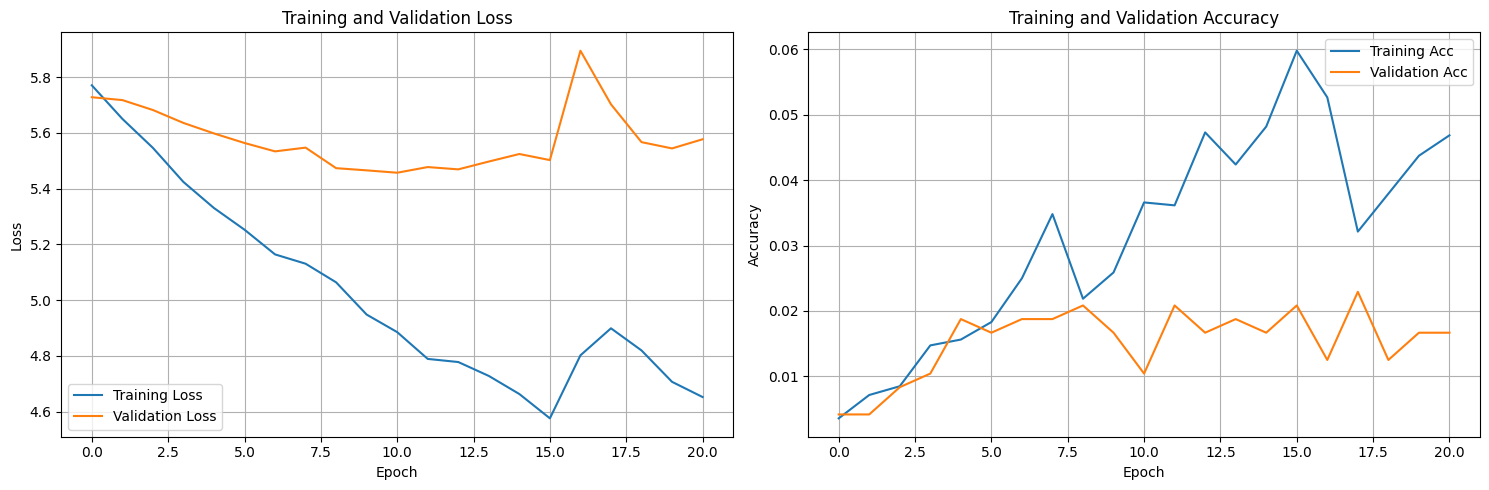

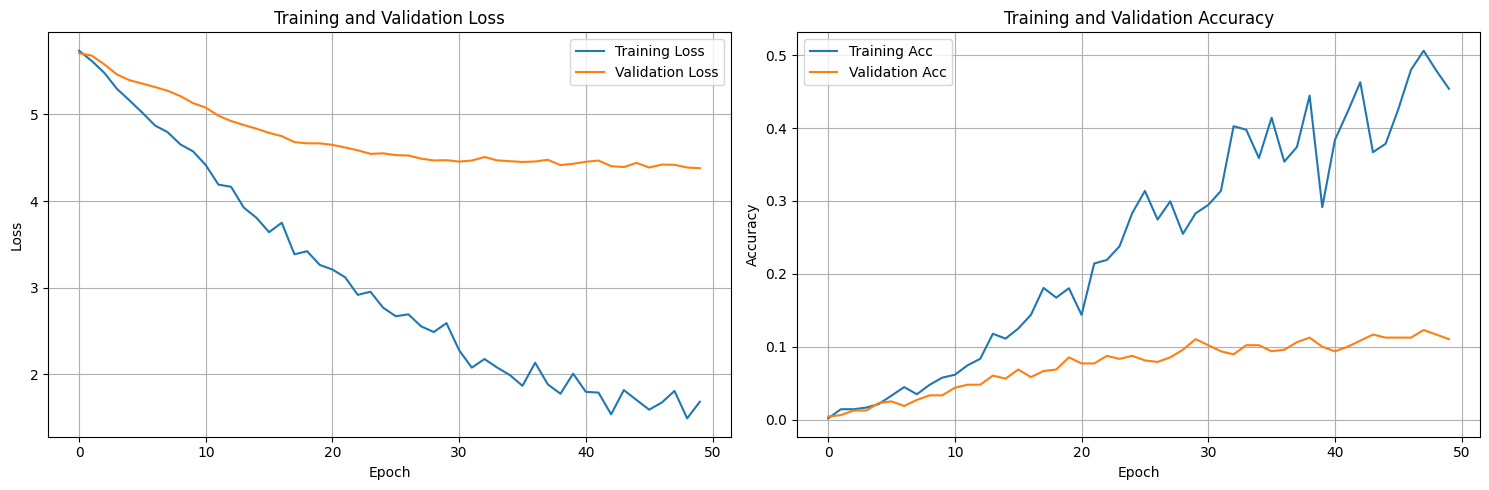

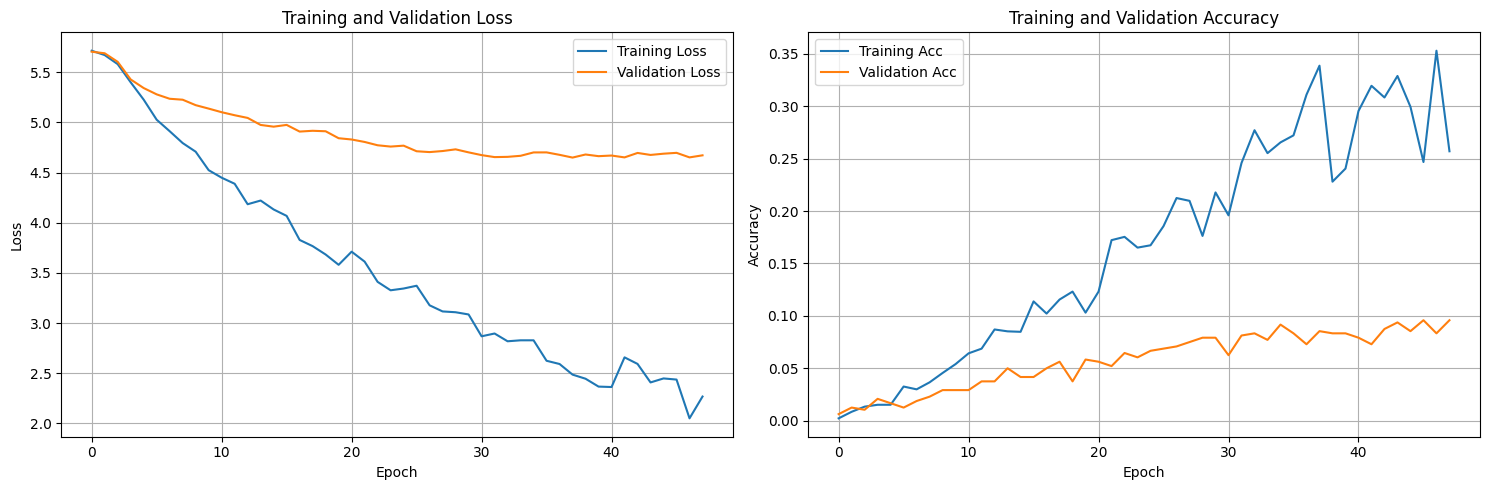

In [24]:
# Training parameters
epochs = 50
lr = 0.001
weight_decay = 1e-4
checkpoint_dir = './checkpoints'

# Create directories for checkpoints and results
os.makedirs(checkpoint_dir, exist_ok=True)

# Results storage
results = {}

# Train each model
for model_name, model in models.items():
    print(f"\n===== Training {model_name} Model =====")
    
    # Create model-specific checkpoint directory
    model_checkpoint_dir = os.path.join(checkpoint_dir, model_name.lower())
    os.makedirs(model_checkpoint_dir, exist_ok=True)
    
    # Create optimizer with weight decay for regularization
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Use class weights if the dataset is imbalanced
    class_counts = np.bincount(y_train)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Create trainer
    trainer = ModelTrainer(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        batch_size=32,
        patience=10,
        checkpoint_dir=model_checkpoint_dir
    )
    
    # Train with one-cycle learning rate schedule
    trained_model, history = trainer.train(
        epochs=epochs,
        scheduler_type='one_cycle',
        scheduler_params={'max_lr': lr * 10},
        use_mixup=True,
        mixup_alpha=0.2,
        use_early_stopping=True
    )
    
    # Save model and training history
    results[model_name] = {
        'model': trained_model,
        'history': history,
        'trainer': trainer
    }
    
    # Plot training history
    print(f"\n{model_name} Training History:")
    trainer.plot_history()

# Model Evaluation

Evaluate each model on the test set and compare their performance.


In [25]:
def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate a model on the test set.
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        criterion: Loss function
        device: Device to evaluate on
    
    Returns:
        Dictionary with loss, accuracy, confusion matrix, etc.
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader, desc="Evaluation")):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Collect predictions and targets for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Calculate metrics
    test_loss /= len(test_loader)
    accuracy = correct / total
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Classification report
    report = classification_report(all_targets, all_preds, output_dict=True)
    
    return {
        'loss': test_loss,
        'accuracy': accuracy,
        'predictions': all_preds,
        'targets': all_targets,
        'confusion_matrix': cm,
        'classification_report': report
    }

# Evaluate each model
evaluation_results = {}
for model_name, result in results.items():
    print(f"\n===== Evaluating {model_name} Model =====")
    
    model = result['model']
    criterion = nn.CrossEntropyLoss()
    
    # Evaluate on test set
    eval_metrics = evaluate_model(model, test_loader, criterion, device)
    evaluation_results[model_name] = eval_metrics
    
    # Print metrics
    print(f"Test Loss: {eval_metrics['loss']:.4f}")
    print(f"Test Accuracy: {eval_metrics['accuracy']:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    report = eval_metrics['classification_report']
    for class_id, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Class {index_to_label.get(int(class_id), class_id)}:")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1-Score: {metrics['f1-score']:.4f}")
            print(f"  Support: {metrics['support']}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = eval_metrics['confusion_matrix']
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=[index_to_label[i] for i in range(len(index_to_label))],
        yticklabels=[index_to_label[i] for i in range(len(index_to_label))]
    )
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f"./checkpoints/{model_name}_confusion_matrix.png")
    plt.show()


===== Evaluating RNN Model =====


Evaluation: 100%|██████████| 16/16 [00:00<00:00, 121.43it/s]

Test Loss: 5.6807
Test Accuracy: 0.0104

Classification Report:
Class about:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 1.0
Class accident:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 2.0
Class africa:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 2.0
Class again:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 2.0
Class all:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 2.0
Class always:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 2.0
Class animal:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 2.0
Class apple:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 2.0
Class approve:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 1.0
Class argue:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 2.0
Class arrive:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 1.0
Class


c:\ProgramData\anaconda3\envs\aslpose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\aslpose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\aslpose\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: invalid literal for int() with base 10: 'macro avg'

# Compare Model Performance

Compare the different models to determine the best one.


In [ ]:
# Compare models
comparison_metrics = {
    'accuracy': [],
    'f1_score': [],
    'average_precision': [],
    'average_recall': []
}

for model_name, eval_results in evaluation_results.items():
    # Extract metrics
    accuracy = eval_results['accuracy']
    report = eval_results['classification_report']
    
    # Calculate macro averages
    avg_precision = report['macro avg']['precision']
    avg_recall = report['macro avg']['recall']
    f1_score = report['macro avg']['f1-score']
    
    # Store metrics
    comparison_metrics['accuracy'].append(accuracy)
    comparison_metrics['f1_score'].append(f1_score)
    comparison_metrics['average_precision'].append(avg_precision)
    comparison_metrics['average_recall'].append(avg_recall)

# Plot comparison
model_names = list(evaluation_results.keys())
metrics = ['accuracy', 'f1_score', 'average_precision', 'average_recall']

plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.2
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    plt.bar(x + offset, comparison_metrics[metric], width, label=metric)
    multiplier += 1

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width, model_names)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("./checkpoints/model_comparison.png")
plt.show()

# Print best model
best_model_idx = np.argmax(comparison_metrics['f1_score'])
best_model_name = model_names[best_model_idx]
print(f"\nBest performing model: {best_model_name}")
print(f"Accuracy: {comparison_metrics['accuracy'][best_model_idx]:.4f}")
print(f"F1 Score: {comparison_metrics['f1_score'][best_model_idx]:.4f}")
print(f"Precision: {comparison_metrics['average_precision'][best_model_idx]:.4f}")
print(f"Recall: {comparison_metrics['average_recall'][best_model_idx]:.4f}")

# Save the Best Model for Deployment

Save the best model with all necessary information for later use.


In [ ]:
# Save the best model for deployment
best_model = results[best_model_name]['model']

# Save model state
torch.save({
    'model_state_dict': best_model.state_dict(),
    'input_size': input_size,
    'hidden_size': hidden_size,
    'output_size': output_size,
    'num_layers': num_layers,
    'dropout_rate': dropout_rate,
    'bidirectional': bidirectional,
    'model_type': best_model_name,
    'label_mapping': index_to_label,
    'feature_mean': feat_mean,
    'feature_std': feat_std,
    'accuracy': comparison_metrics['accuracy'][best_model_idx],
    'f1_score': comparison_metrics['f1_score'][best_model_idx]
}, "./checkpoints/best_model_for_deployment.pt")

print(f"Best model ({best_model_name}) saved for deployment!")

# Create a simplified inference model (optional)
# For deployment, you might want to create a simplified version of the model
# that includes the preprocessing steps, etc.
class InferenceWrapper:
    def __init__(self, model, feature_mean, feature_std, index_to_label):
        self.model = model
        self.feature_mean = feature_mean
        self.feature_std = feature_std
        self.index_to_label = index_to_label
        
    def preprocess(self, input_data):
        # Normalize
        normalized = (input_data - self.feature_mean) / self.feature_std
        return torch.tensor(normalized, dtype=torch.float32).unsqueeze(0)  # Add batch dim
        
    def predict(self, input_data):
        # Preprocess
        x = self.preprocess(input_data)
        
        # Get prediction
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(x)
            _, predicted = torch.max(outputs, 1)
            
        return self.index_to_label[predicted.item()]

# Create and test the inference wrapper
inference_model = InferenceWrapper(
    model=best_model,
    feature_mean=feat_mean,
    feature_std=feat_std,
    index_to_label=index_to_label
)

# Test inference
sample_data = X_test[0]
true_label = index_to_label[y_test[0]]
predicted_label = inference_model.predict(sample_data)

print(f"Sample prediction test:")
print(f"True label: {true_label}")
print(f"Predicted label: {predicted_label}")